In [232]:
import os
import glob

# Definir diretório base
dir = "observations/"
observation_date = "2011-06-26"
base_path = os.path.join(dir, f'{observation_date}/')

# Usar glob para encontrar todos os arquivos .fit no diretório
file_pattern = os.path.join(base_path, '*.fit')
fits_files = sorted(glob.glob(file_pattern))
print(fits_files[0])
image_name = fits_files[0]

observations/2011-06-26/pg1530-001.fit


In [233]:
from astropy.io import fits

# Carregar a imagem FITS
hdu = fits.open(fits_files[0])
print(hdu)
print(hdu[0].data)

image_data = hdu[0].data

[[1326 1333 1334 ... 1307 1326 1323]
 [1330 1302 1316 ... 1304 1309 1325]
 [1321 1318 1325 ... 1328 1338 1329]
 ...
 [1327 1311 1331 ... 1316 1309 1325]
 [1333 1321 1325 ... 1316 1340 1335]
 [1352 1313 1328 ... 1314 1327 1316]]


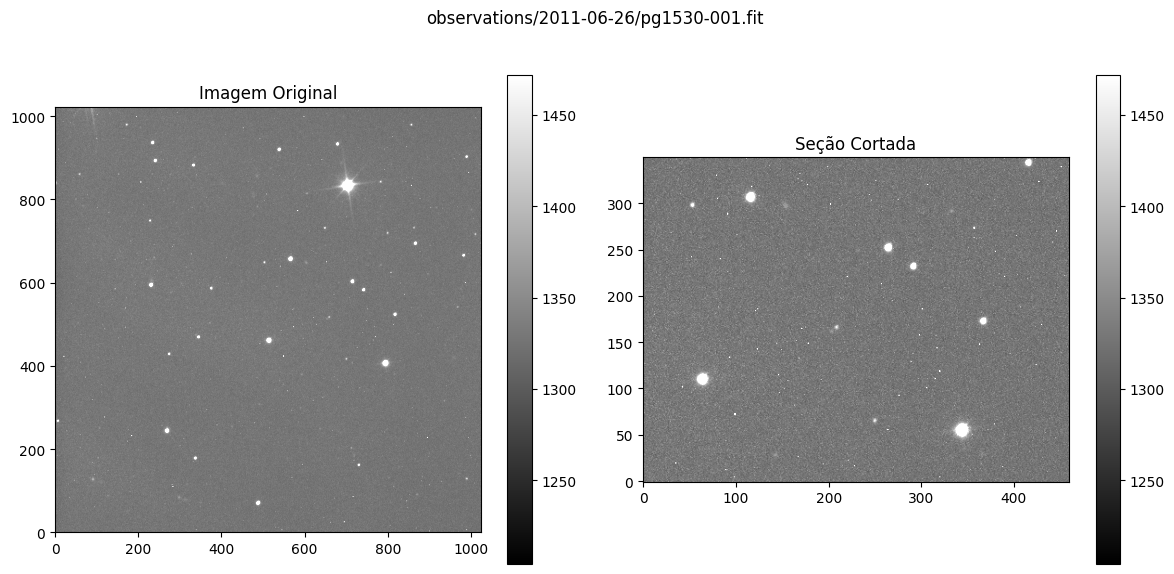

In [488]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Definindo limites de exibição
vmin = np.percentile(image_data, 80)
vmax = np.percentile(image_data, 80)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 linha e 2 colunas
fig.suptitle(image_name)

############
# Original #
############
im1 = ax[0].imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax[0].set_title('Imagem Original')
cbar1 = fig.colorbar(im1, ax=ax[0], orientation='vertical')

###########
# Cropped #
###########
image_section = image_data[350:700,450:910]
im2 =ax[1].imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax[1].set_title('Seção Cortada')
cbar3 = fig.colorbar(im2, ax=ax[1], orientation='vertical')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para dar espaço ao título
plt.show()

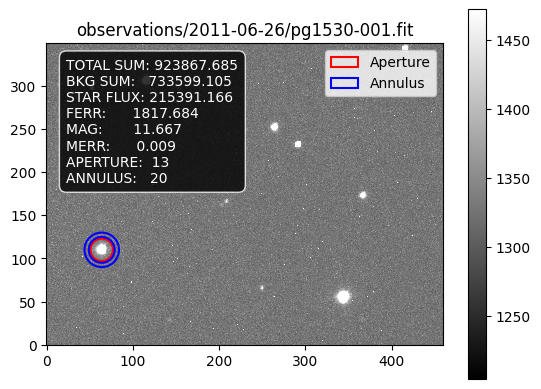

In [493]:

#%matplotlib qt
%matplotlib inline
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats


image_section = image_data[350:700,450:910]

x_cropped_star = 64  # Coordenadas x da estrela
y_cropped_star = 110  # Coordenadas y da estrela

# Raio da abertura
radius_aperture = 13

# Criar apertura
aperture_cropped = CircularAperture((x_cropped_star, y_cropped_star), r=radius_aperture)


# Definir os raios da abertura e do anel
radius_in = 15         # Raio interno do anel (igual ao IRAF)
dannulus  = 5          # Largura do anel de fundo

# Annulus
annulus = CircularAnnulus((x_cropped_star, y_cropped_star), r_in=radius_in, r_out=radius_in + dannulus)

# Fotometria de abertura
photometry = aperture_photometry(image_section, aperture_cropped)

# Contribuição do Céu
bkg       = ApertureStats(image_section, annulus)
bkg_sum   = bkg.sum
bkg_mean  = bkg.mean
total_bkg = bkg_mean  * aperture_cropped.area

star_flux = photometry["aperture_sum"] - total_bkg
FERR = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

zmag     = 25  # IRAF
mag      = zmag -2.5*np.log10(star_flux) if star_flux > 0 else np.inf

if star_flux > 0:
    MERR = (1.0857 * FERR) / star_flux[0]
else:
    MERR = np.inf  # Erro infinito se o fluxo total for zero

# Plotar a imagem com limites definidos
plt.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
aperture_cropped.plot(color='red', lw=1.5, label='Aperture')
annulus.plot(color='blue', lw=1.5, label='Annulus')
plt.colorbar()
plt.title(image_name)
plt.legend()

# Adicionar informações como labels na imagem
textstr = '\n'.join((
    f"TOTAL SUM: {photometry['aperture_sum'][0]:.3f}",
    f"BKG SUM:   {bkg_sum:.3f}",
    f"STAR FLUX: {star_flux.value[0]:.3f}",
    f"FERR:      {FERR:.3f}",
    f"MAG:       {mag.value[0]:.3f}",
    f"MERR:      {MERR:.3f}",
    f"APERTURE:  {radius_aperture}",
    f"ANNULUS:   {radius_in + dannulus}",
))

# Definir a posição do texto (ajuste conforme necessário)
x_text = 0.05 * image_section.shape[1]  # 5% da largura da imagem
y_text = 0.95 * image_section.shape[0]  # 95% da altura da imagem

# Adicionar o texto à imagem
plt.text(x_text,y_text,
         textstr,
         fontsize=10, color='white', ha='left', va='top',
         bbox=dict(boxstyle='round,pad=0.5', edgecolor='white', facecolor='black', alpha=0.8))


# Salvar plot
plt.savefig(f"{image_name.replace('fit','')}")
plt.show()
